# Model Testing & Comparison: Three Models
In this notebook, we will:
1. Load our cleaned and feature-engineered data.
2. Train/Compare **three** models on predicting `ESTIMATED_DELIVERY_MINUTES`:
   - **Random Forest** (simple ML approach)
   - **Basic MLP** (original feed-forward neural network)
   - **Advanced MLP** (deeper/wider neural network)
3. Compare **all** predictions to the dataset's **original** `ESTIMATED_DELIVERY_MINUTES` as well as `ACTUAL_DELIVERY_MINUTES`.
4. Visualize the comparison by day of week, plus show metrics (MSE, MAE) and deviation distributions.

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


script_dir = os.path.dirname(os.path.abspath("."))
sys.path.append(os.path.join(script_dir))

from utils.data_preprocessing import load_data, clean_data
from utils.feature_engineering import add_features
from utils.model_utils import DeliveryTimeModel
from utils.model_utils import AdvancedDeliveryTimeModel

sns.set_style("whitegrid")

## 1. Load & Prepare Data
We'll replicate the cleaning and feature-engineering steps, then split into train/test.

In [2]:
data_path = os.path.join(script_dir, "data", "orders_autumn_2020.csv")
df = load_data(data_path)
df = clean_data(df)
df = add_features(df)

df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df["DAY_OF_WEEK"] = df["TIMESTAMP"].dt.dayofweek

FEATURES = [
    "ITEM_COUNT", "DISTANCE_KM", "HOUR_OF_DAY", "DAY_OF_WEEK", "MONTH",
    "TEMPERATURE_SCALED", "WIND_SPEED_SCALED", "RAIN_INDICATOR"
]
TARGET = "ESTIMATED_DELIVERY_MINUTES"
X = df[FEATURES].values.astype(np.float32)
y = df[TARGET].values.astype(np.float32)
output_plot_dir = os.path.join(script_dir, "figures")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (14964, 8), Test size: (3742, 8)


## 2. Train Model #1: Random Forest (Simple ML)

In [3]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)
print(f"Random Forest - MSE: {rf_mse:.2f}, MAE: {rf_mae:.2f}")

Random Forest - MSE: 36.50, MAE: 4.68


## 3. Train Model #2: Basic MLP (Original)
We reuse the `DeliveryTimeModel` from `utils.model_utils`. Let's train it here quickly.

In [4]:
from utils.model_utils import train_model
train_dataset = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train)
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test),
    torch.from_numpy(y_test)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

mlp_basic = DeliveryTimeModel(input_dim=len(FEATURES), hidden_dim=64)
train_model(mlp_basic, train_loader, epochs=200, lr=1e-3)  # Train for a few epochs

mlp_basic.eval()
with torch.no_grad():
    mlp_preds = mlp_basic(torch.from_numpy(X_test)).squeeze().numpy()

mlp_mse = mean_squared_error(y_test, mlp_preds)
mlp_mae = mean_absolute_error(y_test, mlp_preds)
print(f"Basic MLP - MSE: {mlp_mse:.2f}, MAE: {mlp_mae:.2f}")

Epoch [1/200], Loss: 210.0340
Epoch [2/200], Loss: 68.1633
Epoch [3/200], Loss: 65.2578
Epoch [4/200], Loss: 63.3821
Epoch [5/200], Loss: 62.5905
Epoch [6/200], Loss: 62.2659
Epoch [7/200], Loss: 62.0320
Epoch [8/200], Loss: 62.2500
Epoch [9/200], Loss: 62.1576
Epoch [10/200], Loss: 61.0333
Epoch [11/200], Loss: 60.9439
Epoch [12/200], Loss: 60.4200
Epoch [13/200], Loss: 60.0865
Epoch [14/200], Loss: 59.9413
Epoch [15/200], Loss: 58.9335
Epoch [16/200], Loss: 59.7120
Epoch [17/200], Loss: 58.8401
Epoch [18/200], Loss: 58.8824
Epoch [19/200], Loss: 58.2936
Epoch [20/200], Loss: 58.2462
Epoch [21/200], Loss: 57.5454
Epoch [22/200], Loss: 56.7019
Epoch [23/200], Loss: 57.6593
Epoch [24/200], Loss: 56.1837
Epoch [25/200], Loss: 55.6820
Epoch [26/200], Loss: 55.6201
Epoch [27/200], Loss: 54.9431
Epoch [28/200], Loss: 55.2096
Epoch [29/200], Loss: 54.7050
Epoch [30/200], Loss: 53.7128
Epoch [31/200], Loss: 54.5411
Epoch [32/200], Loss: 53.6892
Epoch [33/200], Loss: 53.6919
Epoch [34/200], Lo

## 4. Train Model #3: Advanced MLP
We use the `AdvancedDeliveryTimeModel` from `utils.model_utils`. Let's train it here.

In [5]:
mlp_advanced = AdvancedDeliveryTimeModel(input_dim=len(FEATURES), hidden_dim=128)
train_model(mlp_advanced, train_loader, epochs=200, lr=1e-3)

mlp_advanced.eval()
with torch.no_grad():
    adv_preds = mlp_advanced(torch.from_numpy(X_test)).squeeze().numpy()

adv_mse = mean_squared_error(y_test, adv_preds)
adv_mae = mean_absolute_error(y_test, adv_preds)
print(f"Advanced MLP - MSE: {adv_mse:.2f}, MAE: {adv_mae:.2f}")

Epoch [1/200], Loss: 166.5350
Epoch [2/200], Loss: 69.3111
Epoch [3/200], Loss: 65.3012
Epoch [4/200], Loss: 65.4101
Epoch [5/200], Loss: 64.7260
Epoch [6/200], Loss: 62.8054
Epoch [7/200], Loss: 61.6240
Epoch [8/200], Loss: 61.7652
Epoch [9/200], Loss: 60.6709
Epoch [10/200], Loss: 60.4672
Epoch [11/200], Loss: 59.6725
Epoch [12/200], Loss: 59.9258
Epoch [13/200], Loss: 59.2805
Epoch [14/200], Loss: 58.2507
Epoch [15/200], Loss: 57.6827
Epoch [16/200], Loss: 58.0633
Epoch [17/200], Loss: 58.4794
Epoch [18/200], Loss: 57.2550
Epoch [19/200], Loss: 57.3317
Epoch [20/200], Loss: 56.9580
Epoch [21/200], Loss: 55.0487
Epoch [22/200], Loss: 55.8402
Epoch [23/200], Loss: 55.4960
Epoch [24/200], Loss: 54.3088
Epoch [25/200], Loss: 54.5052
Epoch [26/200], Loss: 53.8500
Epoch [27/200], Loss: 54.8506
Epoch [28/200], Loss: 53.1308
Epoch [29/200], Loss: 53.7263
Epoch [30/200], Loss: 52.5383
Epoch [31/200], Loss: 52.1083
Epoch [32/200], Loss: 51.0055
Epoch [33/200], Loss: 51.9300
Epoch [34/200], Lo

### Compare All Models with Original Estimate
The original dataset has `ESTIMATED_DELIVERY_MINUTES` and `ACTUAL_DELIVERY_MINUTES`. Let’s see how they differ from our three new models.

In [6]:
df_test_indices = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
X_train_df, X_test_df = train_test_split(df, test_size=0.2, random_state=42)
df_test = X_test_df.copy().reset_index(drop=True)  # separate copy
df_test["PRED_RF"] = rf_model.predict(df_test[FEATURES])
df_test["PRED_MLP_BASIC"] = mlp_basic(
    torch.from_numpy(df_test[FEATURES].values.astype(np.float32))
).squeeze().detach().numpy()
df_test["PRED_MLP_ADV"] = mlp_advanced(
    torch.from_numpy(df_test[FEATURES].values.astype(np.float32))
).squeeze().detach().numpy()

print(df_test[["ACTUAL_DELIVERY_MINUTES", "ESTIMATED_DELIVERY_MINUTES", "PRED_RF", "PRED_MLP_BASIC", "PRED_MLP_ADV"]].head())

   ACTUAL_DELIVERY_MINUTES  ESTIMATED_DELIVERY_MINUTES  PRED_RF  \
0                       44                          28    30.14   
1                       40                          37    43.78   
2                       26                          31    35.70   
3                       32                          35    28.54   
4                       25                          23    29.08   

   PRED_MLP_BASIC  PRED_MLP_ADV  
0       32.815781     31.763491  
1       37.222584     38.458000  
2       31.554451     31.648262  
3       32.270622     31.745813  
4       29.588480     28.484505  


/Users/tuanvu/Documents/deep_learning_course/ex_1/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


## 5. Plot Comparisons by Day-of-Week
We’ll group test data by day-of-week and compare **actual** vs. **original estimate** vs. **RF** vs. **Basic MLP** vs. **Advanced MLP** (averaged).

In [7]:
df_test["TIMESTAMP"] = pd.to_datetime(df_test["TIMESTAMP"])
df_test["DAY_OF_WEEK"] = df_test["TIMESTAMP"].dt.dayofweek
group_cols = [
    "ACTUAL_DELIVERY_MINUTES",
    "ESTIMATED_DELIVERY_MINUTES",
    "PRED_RF",
    "PRED_MLP_BASIC",
    "PRED_MLP_ADV"
]
agg_df = df_test.groupby("DAY_OF_WEEK")[group_cols].mean().reset_index()
agg_df

,DAY_OF_WEEK,ACTUAL_DELIVERY_MINUTES,ESTIMATED_DELIVERY_MINUTES,PRED_RF,PRED_MLP_BASIC,PRED_MLP_ADV
0,0,33.187638,34.518764,34.758422,35.016495,34.706436
1,1,32.079646,33.761062,34.070664,34.408493,34.031563
2,2,31.125954,32.866412,33.298505,33.833809,33.669346
3,3,32.404396,33.641758,33.398689,34.367397,34.065922
4,4,32.756957,34.512059,34.461387,33.742489,33.584038
5,5,31.608371,32.729447,32.932750,34.029411,33.442509
6,6,33.204615,34.504615,34.004986,34.553986,34.351334


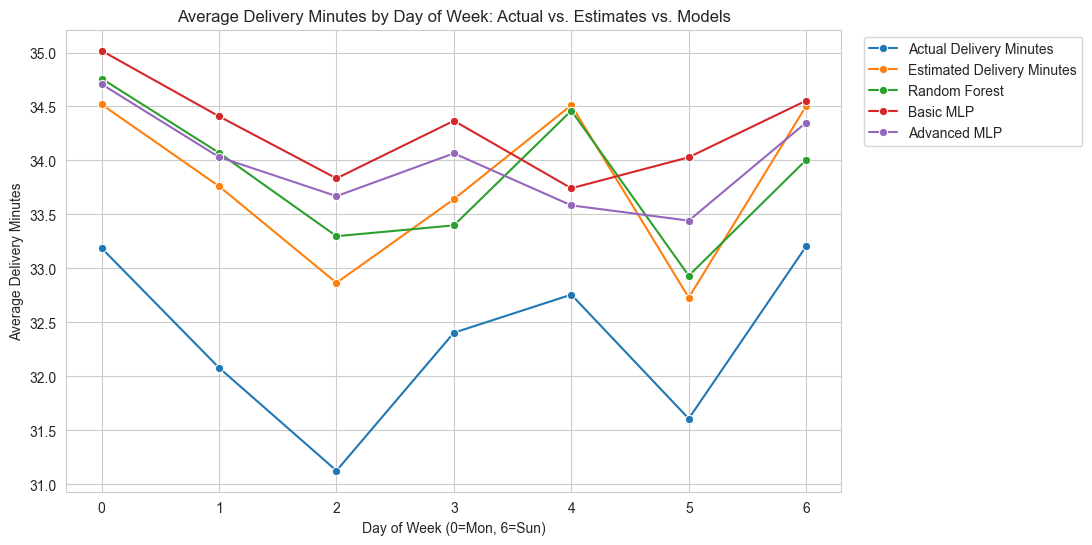

In [8]:
group_cols = [
    "Actual Delivery Minutes",
    "Estimated Delivery Minutes",
    "Random Forest",
    "Basic MLP",
    "Advanced MLP"
]
agg_df.columns = ["DAY_OF_WEEK"] + group_cols
melted = agg_df.melt(id_vars=["DAY_OF_WEEK"],
                    value_vars=group_cols,
                    var_name="Series", value_name="AvgMinutes")
plt.figure(figsize=(10,6))
sns.lineplot(data=melted, x="DAY_OF_WEEK", y="AvgMinutes", hue="Series", marker="o")
plt.title("Average Delivery Minutes by Day of Week: Actual vs. Estimates vs. Models")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Average Delivery Minutes")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.savefig(os.path.join(output_plot_dir, "delivery_comparison.png"), dpi=300, bbox_inches="tight")
plt.show()

## 6. Summary of Model Performance
Let's compile final MSE/MAE metrics for a quick table.

In [9]:
orig_mse = mean_squared_error(df_test["ACTUAL_DELIVERY_MINUTES"], df_test["ESTIMATED_DELIVERY_MINUTES"])
orig_mae = mean_absolute_error(df_test["ACTUAL_DELIVERY_MINUTES"], df_test["ESTIMATED_DELIVERY_MINUTES"])
results_summary = pd.DataFrame({
    "Model": ["Original Estimate", "Random Forest", "Basic MLP", "Advanced MLP"],
    "MSE": [orig_mse, rf_mse, mlp_mse, adv_mse],
    "MAE": [orig_mae, rf_mae, mlp_mae, adv_mae]
})
results_summary

,Model,MSE,MAE
0,Original Estimate,81.979423,7.226884
1,Random Forest,36.495617,4.676626
2,Basic MLP,37.328732,4.791783
3,Advanced MLP,36.053932,4.700769


### 7. Visualize the Results

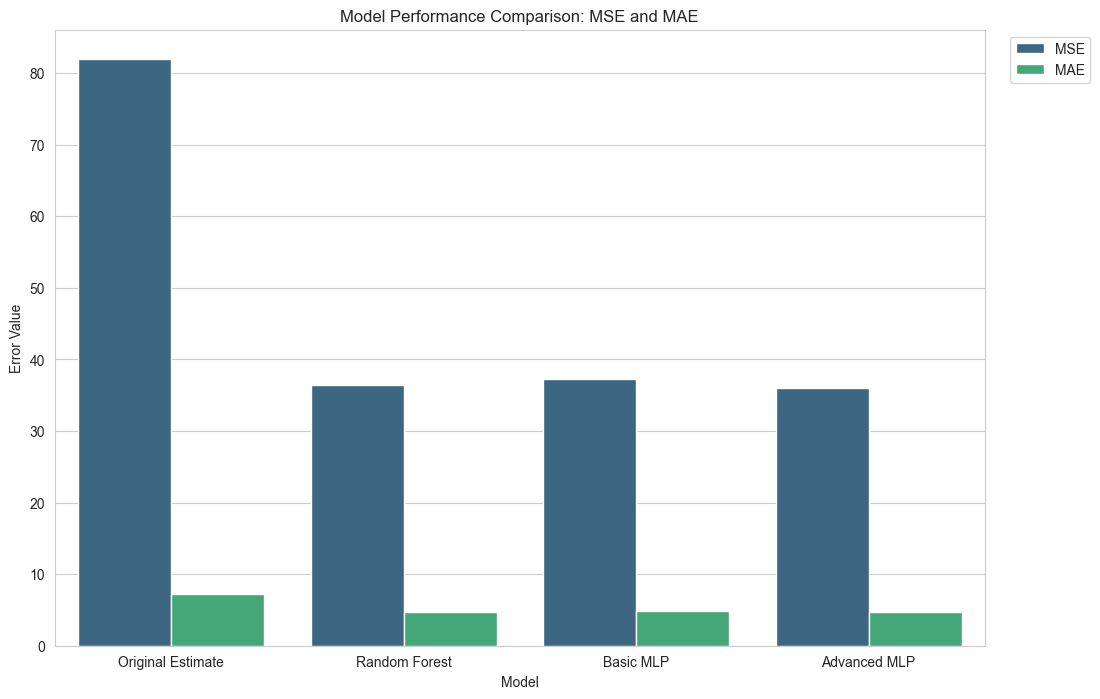

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results_summary = pd.DataFrame({
    "Model": ["Original Estimate", "Random Forest", "Basic MLP", "Advanced MLP"],
    "MSE": [orig_mse, rf_mse, mlp_mse, adv_mse],
    "MAE": [orig_mae, rf_mae, mlp_mae, adv_mae]
})
melted_results = results_summary.melt(id_vars=["Model"], value_vars=["MSE", "MAE"], var_name="Metric", value_name="Value")
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_results, x="Model", y="Value", hue="Metric", palette="viridis")
plt.title("Model Performance Comparison: MSE and MAE")
plt.xlabel("Model")
plt.ylabel("Error Value")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.savefig(os.path.join(output_plot_dir, "model_comparison.png"), dpi=300, bbox_inches="tight")
plt.show()

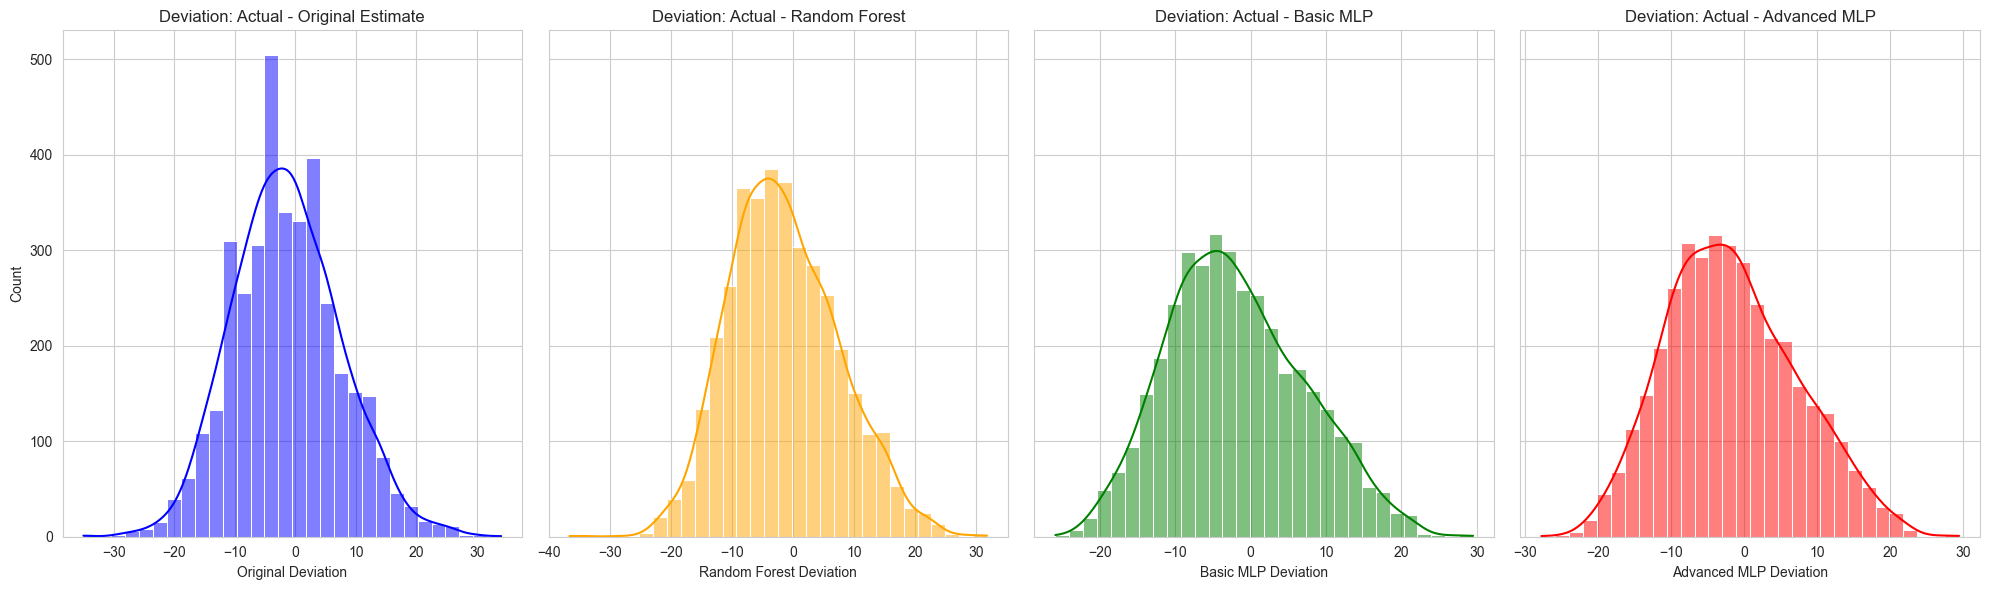

In [11]:
df_test["Original Deviation"] = df_test["ACTUAL_DELIVERY_MINUTES"] - df_test["ESTIMATED_DELIVERY_MINUTES"]
df_test["Random Forest Deviation"] = df_test["ACTUAL_DELIVERY_MINUTES"] - df_test["PRED_RF"]
df_test["Basic MLP Deviation"] = df_test["ACTUAL_DELIVERY_MINUTES"] - df_test["PRED_MLP_BASIC"]
df_test["Advanced MLP Deviation"] = df_test["ACTUAL_DELIVERY_MINUTES"] - df_test["PRED_MLP_ADV"]

fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

sns.histplot(df_test["Original Deviation"], bins=30, kde=True, ax=ax[0], color='blue')
ax[0].set_title("Deviation: Actual - Original Estimate")

sns.histplot(df_test["Random Forest Deviation"], bins=30, kde=True, ax=ax[1], color='orange')
ax[1].set_title("Deviation: Actual - Random Forest")

sns.histplot(df_test["Basic MLP Deviation"], bins=30, kde=True, ax=ax[2], color='green')
ax[2].set_title("Deviation: Actual - Basic MLP")

sns.histplot(df_test["Advanced MLP Deviation"], bins=30, kde=True, ax=ax[3], color='red')
ax[3].set_title("Deviation: Actual - Advanced MLP")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, "deviation_comparison.png"), dpi=300)
plt.show()

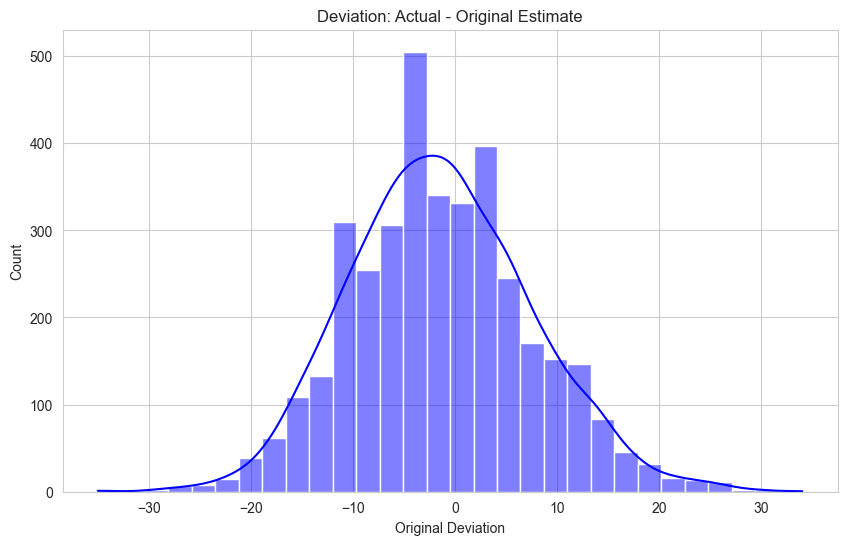

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df_test["Original Deviation"], bins=30, kde=True, ax=ax, color='blue')
ax.set_title("Deviation: Actual - Original Estimate")

output_plot_dir = os.path.join(script_dir, "figures")
os.makedirs(output_plot_dir, exist_ok=True)
plt.savefig(os.path.join(output_plot_dir, "original_deviation_plot.png"), dpi=300)
plt.show()